In [21]:
import torch
import os
import time
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import sys
import yaml
import zipfile
import requests
os.environ["KAGGLE_KEY"] = "ankitht"
os.environ["KAGGLE_USERNAME"] = "dde58a57a33baa717acaea4fe7fc203"
import kaggle

torch.set_printoptions(sci_mode=False)
from vanilla_vae import VanillaVAE



In [22]:

dataset_name = "farzadnekouei/top-view-vehicle-detection-image-dataset"

kaggle.api.dataset_download_files(dataset_name,path="..")
with zipfile.ZipFile("../top-view-vehicle-detection-image-dataset.zip") as zf:
        zf.extractall("..")

Dataset URL: https://www.kaggle.com/datasets/farzadnekouei/top-view-vehicle-detection-image-dataset


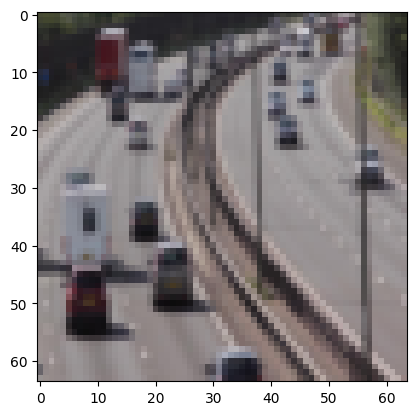

In [50]:
class VehicleDataset(Dataset):
    def __init__(self,image_dir,label_dir,transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform

        self.image_files = sorted(os.listdir(image_dir))
        self.label_files = sorted(os.listdir(label_dir))
    
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.image_dir, self.image_files[idx]))
        #Convert color to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, 0

def display_sample(image):
    #Displays sample image from dataset
    image = image.permute(1,2,0).numpy()
    image = (image + 1) / 2
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    plt.show()


train_images = "../Vehicle_Detection_Image_Dataset/train/images"

train_labels = "../Vehicle_Detection_Image_Dataset/train/labels"

valid_images = "../Vehicle_Detection_Image_Dataset/valid/images"

valid_labels = "../Vehicle_Detection_Image_Dataset/valid/labels"
        

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64,64)), #What model size
    transforms.ToTensor(),
    transforms.Normalize([.5,.5,.5],[.5,.5,.5])

])



train_dataset = VehicleDataset(train_images,train_labels,transform)
train_dataloader = DataLoader(train_dataset,batch_size=20,shuffle=True)

valid_dataset = VehicleDataset(valid_images,valid_labels,transform) #Oops, shouldn't be transforming the test dataset as well
valid_dataloader = DataLoader(valid_dataset,batch_size=20)
%matplotlib inline

display_sample(train_dataset[0][0])


In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
kld_weight = .00025

latent_dimension = 1000
model = VanillaVAE(3,latent_dimension,hidden_dims=None)
model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

num_epochs = 30

In [56]:


for epoch in range(num_epochs):
    model.train()
    for images, _ in train_dataloader:
        images = images.to(device)

        recons, input, mu, log_var = model(images)
        loss_dict = model.loss_function(recons, input, mu, log_var,kld_weight)

        optimizer.zero_grad()

        loss_dict["loss"].backward()

        optimizer.step()
    avg_test_loss_dict =  {'loss': 0, 'Reconstruction_Loss':0, 'KLD':0}
    count = 0
    model.eval()
    with torch.inference_mode():
        for images, _ in valid_dataloader:
            images = images.to(device)
            recons, input, mu, log_var = model(images)

            loss_dict = model.loss_function(recons, input, mu, log_var,kld_weight)
            
            avg_test_loss_dict["loss"] += loss_dict["loss"]
            avg_test_loss_dict["Reconstruction_Loss"] += loss_dict["Reconstruction_Loss"]
            avg_test_loss_dict["KLD"] += loss_dict["KLD"]

            count += 1
        avg_test_loss_dict["loss"] /= count
        avg_test_loss_dict["Reconstruction_Loss"]  /= count
        avg_test_loss_dict["KLD"]  /= count
        reconstructed_image = torch.squeeze(model.sample(1,current_device=device)).to("cpu").detach()
        display_sample(torch.squeeze(reconstructed_image))  
    print(f" Epoch: {epoch+1}: {avg_test_loss_dict}")

print("Training Complete")


torch.Size([1, 3, 64, 64])


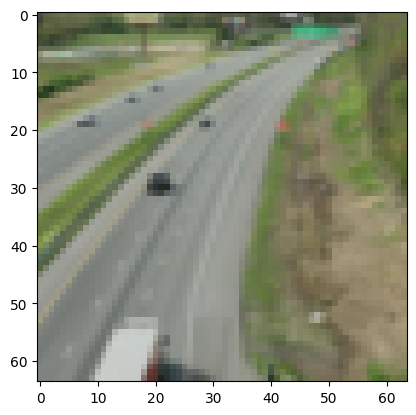

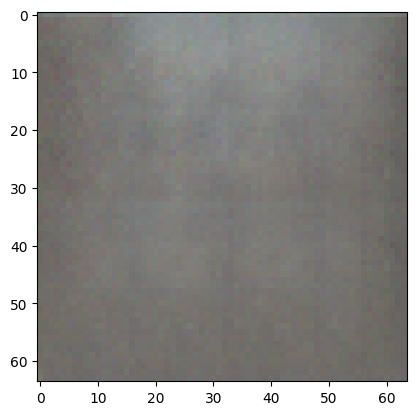

tensor([[[-0.1394, -0.0665, -0.0583,  ..., -0.0176, -0.0903, -0.0874],
         [-0.0968, -0.0828, -0.0926,  ..., -0.1292, -0.1493, -0.1594],
         [-0.1650, -0.0803, -0.1000,  ..., -0.0957, -0.1159, -0.1713],
         ...,
         [-0.0768, -0.1380, -0.1351,  ..., -0.1798, -0.2011, -0.1668],
         [-0.1041, -0.0940, -0.1128,  ..., -0.1305, -0.1294, -0.1217],
         [-0.0421, -0.1167, -0.1211,  ..., -0.1528, -0.1209, -0.1522]],

        [[-0.0744,  0.0163,  0.0109,  ..., -0.0062, -0.0156, -0.0695],
         [-0.1730, -0.1399, -0.1082,  ..., -0.0911, -0.1581, -0.1953],
         [-0.1271, -0.2019, -0.1373,  ..., -0.0909, -0.1722, -0.1682],
         ...,
         [-0.1551, -0.1545, -0.1859,  ..., -0.1645, -0.1679, -0.1852],
         [-0.0964, -0.1460, -0.1700,  ..., -0.1491, -0.1714, -0.2127],
         [-0.0775, -0.1591, -0.1705,  ..., -0.1774, -0.1536, -0.1864]],

        [[-0.1186, -0.0226, -0.0633,  ..., -0.0905, -0.0667, -0.1578],
         [-0.2257, -0.1197, -0.1808,  ..., -0

In [53]:
image = valid_dataset[20][0][np.newaxis,:,:,:].to(device)
print(image.shape)
reconstructed_image = torch.squeeze(model.generate(image)).to("cpu").detach()
display_sample(torch.squeeze(image.to("cpu")))
display_sample(reconstructed_image)
print(reconstructed_image)

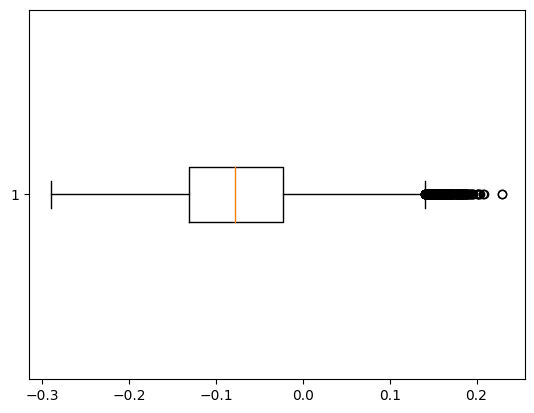

In [54]:
plt.boxplot(reconstructed_image.view(-1),vert=False)
plt.show()